In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from models.model_fpgan import FPGANSynthesizer
from models.model_ctgan import CTGANSynthesizer
from models.model_dpctgan import DPCTGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity, get_accuracy, get_roc_auc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [21]:
data = pd.read_csv("D:/Datasets/lung/data.csv")
data = data.drop(columns=['index','Patient Id'])

data.Level = data.Level.replace("Low", 0)
data.Level = data.Level.replace("Medium", 0)
data.Level = data.Level.replace("High", 1)

data.Level = data.Level.astype("int64")

data.head()

,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,33,1,2,4,5,4,3,2,2,4,...,3,4,2,2,3,1,2,3,4,0
1,17,1,3,1,5,3,4,2,2,2,...,1,3,7,8,6,2,1,7,2,0
2,35,1,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,1
3,37,1,7,7,7,7,6,7,7,7,...,4,2,3,1,4,5,6,7,5,1
4,46,1,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,1


In [22]:
data.shape

(1000, 24)

In [23]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())

In [24]:
target = 'Level'

In [25]:
X = data.drop(columns=[target])
y = data[target]

In [27]:
#model_ctgan = CTGANSynthesizer(epochs=100, verbose=True)
#model_ctgan = DPCTGANSynthesizer(verbose=True)
model_ctgan = FPGANSynthesizer(epochs=100, verbose=True)
#original_losses, tranformed_privacies, losses = model_ctgan.fit(data)
model_ctgan.fit(data)

Epoch 1, Loss G: -0.1960,Loss D: -0.0192
Epoch 2, Loss G: -0.1963,Loss D: -0.0678
Epoch 3, Loss G: -0.1879,Loss D: -0.1123
Epoch 4, Loss G: -0.1750,Loss D: -0.2195
Epoch 5, Loss G: -0.1700,Loss D: -0.2469
Epoch 6, Loss G: -0.1724,Loss D: -0.3654
Epoch 7, Loss G: -0.1838,Loss D: -0.3107
Epoch 8, Loss G: -0.2201,Loss D: -0.1632
Epoch 9, Loss G: -0.2679,Loss D:  0.0677
Epoch 10, Loss G: -0.2874,Loss D:  0.2545
Epoch 11, Loss G: -0.3177,Loss D:  0.4472
Epoch 12, Loss G: -0.3375,Loss D:  0.4202
Epoch 13, Loss G: -0.3285,Loss D:  0.3018
Epoch 14, Loss G: -0.3094,Loss D:  0.0341
Epoch 15, Loss G: -0.2933,Loss D: -0.0838
Epoch 16, Loss G: -0.2577,Loss D: -0.2393
Epoch 17, Loss G: -0.2478,Loss D: -0.3961
Epoch 18, Loss G: -0.2477,Loss D: -0.3661
Epoch 19, Loss G: -0.2369,Loss D: -0.5335
Epoch 20, Loss G: -0.2839,Loss D: -0.0087
Epoch 21, Loss G: -0.2857,Loss D:  0.0785
Epoch 22, Loss G: -0.3163,Loss D:  0.3761
Epoch 23, Loss G: -0.3179,Loss D:  0.5104
Epoch 24, Loss G: -0.3385,Loss D:  0.4973
E

([array(0.03713959, dtype=float32),
  array(0.03046308, dtype=float32),
  array(0.0332956, dtype=float32),
  array(0.03311364, dtype=float32),
  array(0.05057342, dtype=float32),
  array(0.05208537, dtype=float32),
  array(0.06647673, dtype=float32),
  array(0.07812729, dtype=float32),
  array(0.08105392, dtype=float32),
  array(0.08545839, dtype=float32),
  array(0.07860409, dtype=float32),
  array(0.07848136, dtype=float32),
  array(0.06820545, dtype=float32),
  array(0.05347972, dtype=float32),
  array(0.01161667, dtype=float32),
  array(-0.02153077, dtype=float32),
  array(-0.04048585, dtype=float32),
  array(-0.11540775, dtype=float32),
  array(-0.12725201, dtype=float32),
  array(-0.15250672, dtype=float32),
  array(-0.19687566, dtype=float32),
  array(-0.2092263, dtype=float32),
  array(-0.23490109, dtype=float32),
  array(-0.24793784, dtype=float32),
  array(-0.2463177, dtype=float32),
  array(-0.22907054, dtype=float32),
  array(-0.2175091, dtype=float32),
  array(-0.19454196,

In [28]:
from utils.utils import save_models
save_models(model_ctgan, 'fpgan100', 'lung')

In [17]:
from utils.utils import load_models
model_ctgan = load_models('dpctgan3', 'lung')

In [18]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [19]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame
samples = samples[:2000]
data = data[:2000]

In [20]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.33275204]


## Fidelity

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42, stratify=y_syn)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test, undersample=False)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test, undersample=False)

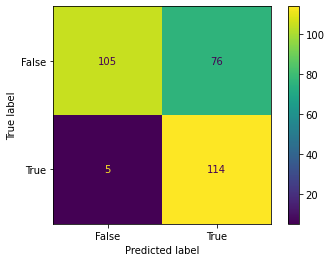

In [24]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [25]:
percentage, class1_ratio, class2_ratio = eval_fidelity(rr_pred, fr_pred)

In [26]:
rr_acc = get_accuracy(y_test, rr_pred)
fr_acc = get_accuracy(y_test, fr_pred)
print("Accuracy of real data: ", rr_acc)
print("Accuracy of synthetic data: ", fr_acc)

Accuracy of real data:  1.0
Accuracy of synthetic data:  0.73


In [27]:
rr_score = get_roc_auc(y_test, rr_pred)
fr_score = get_roc_auc(y_test, fr_pred)
print("ROC AUC of real data: ", rr_score)
print("ROC AUC of synthetic data: ", fr_score)

ROC AUC of real data:  1.0
ROC AUC of synthetic data:  0.76904684525744


In [28]:
print(class1_ratio, class2_ratio)

0.5645161290322581 0.5846153846153846


## Final plot

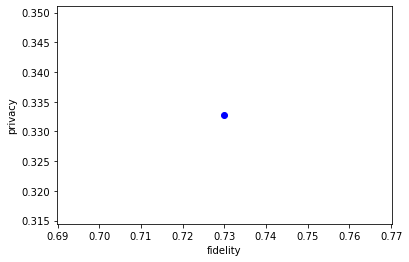

0.73 [0.33275204]


In [29]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()
print(percentage, normalized_avg_distance)